Modified by Miguel V. Martin March 2023 from Moroney's code, for AI Programming course (MBAI5310).

In [1]:
# Honour Code
# I, Maaz Saad, hereby give my word of honour that I am the sole author of the work as submitted in the 
# answers to this midterm examination. I didn’t collaborate with anyone and didn’t let anybody copy my work. 
# If I used code written by someone else, I clearly and explicitly acknowledged the source using comments 
# within the Python code, and I am aware that I will not receive any credits solely for code written by 
# someone else. Further, I am aware that failing to clearly credit the source/author of the reused code 
# will be considered academic misconduct. I didn’t post or submit, and will never post or submit, 
# questions or answers, or parts of questions or answers of this midterm to a third party 
# (except for my submission in Canvas for this midterm).

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
tf.keras.utils.set_random_seed(42)
print(tf.__version__)

2.11.0


In [4]:
from google.colab import files
my_raw_files = files.upload()

Saving TSLA.csv to TSLA.csv


In [5]:
df = pd.read_csv("TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,20.462667,20.475332,19.459999,19.652666,19.652666,343671000
1,3/4/2019,19.874666,19.933332,18.851999,19.024000,19.024000,256452000
2,3/5/2019,18.799999,18.933332,18.006666,18.436001,18.436001,281470500
3,3/6/2019,18.431999,18.767332,18.292667,18.416000,18.416000,155032500
4,3/7/2019,18.589333,18.980000,18.283333,18.439333,18.439333,141637500


(1020, 7)


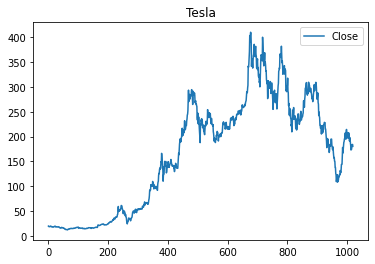

In [6]:
print(df.shape)
df[['Close']].plot()
plt.title("Tesla")
plt.show()

In [7]:
def plot_series(time, series, format="-", label=None, start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

series = tf.convert_to_tensor(df['Close'])
time = np.arange(1020)

split_time = 1000 #SET THE SPLIT_TIME
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20 #SET THE WINDOW_SIZE
batch_size = 32 #SET THE BATCH_SIZE
shuffle_buffer_size = 1000 #SET THE SHUFFLE_BUFFER_SIZE

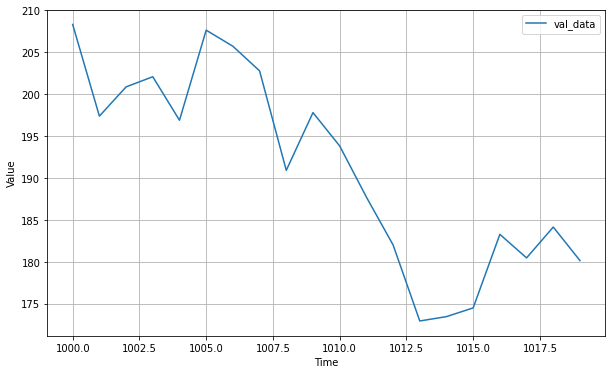

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='val_data')

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=[window_size], activation="relu"), 
    #YOU MAY OR MAY NOT ADD LAYERS
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)) #YOU MAY OR MAY NOT CHANGE THE LEARNING_RATE
model.fit(dataset,epochs=100,verbose=2) #DO NOT CHANGE EPOCHS, LEAVE IT AT 100



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
31/31 - 7s - loss: 4976.4619 - 7s/epoch - 241ms/step
Epoch 2/100
31/31 - 0s - loss: 240.5021 - 316ms/epoch - 10ms/step
Epoch 3/100
31/31 - 0s - loss: 158.4695 - 328ms/epoch - 11ms/step
Epoch 4/100
31/31 - 0s - loss: 155.2587 - 302ms/epoch - 10ms/step
Epoch 5/100
31/31 - 0s - loss: 152.7564 - 176ms/epoch - 6ms/step
Epoch 6/100
31/31 - 0s - loss: 150.9034 - 161ms/epoch - 5ms/step
Epoch 7/100
31/31 - 0s - loss: 148.9012 - 148ms/epoch - 5ms/step
Epoch 8/100
31/31 - 0s - loss: 147.3004 - 149ms/epoch - 5ms/step
Epoch 9/100
31/31 - 0s - loss: 144.8748 - 142ms/epoch - 5ms/step
Epoch 10/100
31/31 - 0s - loss: 143.4885 - 150ms/epoch - 5ms/step
Epoch 11/100
31/31 - 0s - loss: 142.1353 - 163ms/epoch - 5ms/step
Epoch 12/100
31/31 - 0s - loss: 140.3681 - 163ms/epoch - 5ms/step
Epoch 13/100
31/31 - 0s - loss: 138.8104 - 141ms/epoch - 5ms/step
Epoch 14/100
31/31 - 0s - loss: 138.5135 - 142ms/epoch - 5ms/step
Epoch 15/100
31/31 - 0s - loss: 135.9258 - 158ms/epoch - 5ms/step
Epoch 16/100
31/

6.0492034

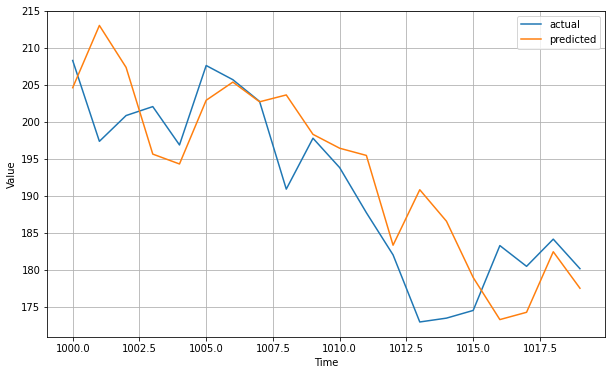

In [11]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=0))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid, label='actual')
plot_series(time_valid, results, label='predicted')

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# MAE = 6.0492034